In [15]:
## Make width of notebook 90%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [17]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

Home team has winrate of 59.1%

# Remove non-data

In [18]:
cumulative_stats_copy_df = cumulative_stats_df.copy()

# Remove rows where games_played==0
cumulative_stats_copy_df = cumulative_stats_copy_df.loc[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & cumulative_stats_copy_df['GAMES_PLAYED_away']>0]

for key in ['DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away']:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']

# Add hometeam win/loss column
cumulative_stats_copy_df['HOME_WIN'] = winners_df
cumulative_stats_copy_df['HOME_HIGHER_FG_PCT'] = greater_fgp_df
cumulative_stats_copy_df['HOME_HIGHER_FG3_PCT'] = greater_fg3_df
cumulative_stats_copy_df['HOME_HIGHER_FT_PCT'] = greater_ft_df
cumulative_stats_copy_df['HOME_HIGHER_AST'] = greater_ast_df
cumulative_stats_copy_df['HOME_HIGHER_REB'] = greater_reb_df

cumulative_stats_copy_df

,APG_total_home,FG_PCT_total_home,FG3_PCT_total_home,FT_PCT_total_home,PPG_total_home,RPG_total_home,APG_total_away,FG_PCT_total_away,FG3_PCT_total_away,FT_PCT_total_away,PPG_total_away,RPG_total_away,W_PCT_away,W_PCT_home,HOME_WIN,HOME_HIGHER_FG_PCT,HOME_HIGHER_FG3_PCT,HOME_HIGHER_FT_PCT,HOME_HIGHER_AST,HOME_HIGHER_REB
0,23.000000,0.457000,0.143000,0.735000,90.000000,41.000000,20.000000,0.447000,0.250000,0.500000,85.000000,38.000000,0.000,0.000,1,0,0,0,1,0
1,25.000000,0.494000,0.267000,0.618000,105.000000,48.000000,20.000000,0.427000,0.154000,0.700000,94.000000,43.000000,0.000,0.000,1,1,0,0,1,0
2,19.000000,0.467000,0.444000,0.871000,101.000000,39.000000,13.000000,0.368000,0.364000,0.609000,82.000000,50.000000,0.000,0.000,0,0,1,0,0,0
3,22.000000,0.527000,0.429000,0.657000,104.000000,33.000000,10.000000,0.470000,0.333000,0.667000,80.000000,37.000000,0.000,0.000,0,0,0,1,0,0
4,15.000000,0.352000,0.222000,0.647000,86.000000,55.000000,7.000000,0.329000,0.143000,0.897000,79.000000,44.000000,0.000,0.000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23505,24.000000,0.409750,0.299000,0.709000,110.500000,48.500000,24.333333,0.429667,0.347333,0.732333,111.000000,48.666667,0.667,0.500,1,1,1,0,1,1
23506,21.666667,0.427333,0.364000,0.741667,97.333333,42.000000,25.666667,0.474000,0.395000,0.776000,118.333333,46.333333,1.000,0.000,1,1,1,0,1,1
23507,25.666667,0.433667,0.442667,0.826333,122.333333,48.333333,21.333333,0.422000,0.345000,0.754000,112.666667,51.000000,0.333,0.667,1,1,0,1,0,0
23508,30.666667,0.466667,0.329333,0.704667,119.333333,52.666667,24.000000,0.392667,0.332333,0.789667,111.333333,56.000000,0.333,1.000,0,0,0,1,0,0


In [19]:
standardized_stats_data_df = pd.DataFrame(StandardScaler().fit_transform(cumulative_stats_copy_df), columns=cumulative_stats_copy_df.columns)

# Covariance Matrix

In [20]:
standardized_stats_data_df.cov().style.background_gradient(cmap='rainbow',axis=None)

,APG_total_home,FG_PCT_total_home,FG3_PCT_total_home,FT_PCT_total_home,PPG_total_home,RPG_total_home,APG_total_away,FG_PCT_total_away,FG3_PCT_total_away,FT_PCT_total_away,PPG_total_away,RPG_total_away,W_PCT_away,W_PCT_home,HOME_WIN,HOME_HIGHER_FG_PCT,HOME_HIGHER_FG3_PCT,HOME_HIGHER_FT_PCT,HOME_HIGHER_AST,HOME_HIGHER_REB
APG_total_home,1.000084,0.534466,0.275478,0.128503,0.633738,0.268466,0.218844,0.086389,0.035620,0.125111,0.329868,0.200392,0.007456,0.292109,-0.008725,-0.005179,-0.004687,-0.001479,-0.011304,-0.010814
FG_PCT_total_home,0.534466,1.000084,0.442977,0.139015,0.576696,-0.029818,0.084932,0.107851,0.048004,0.119852,0.172713,-0.065230,-0.062952,0.461575,0.005374,0.006374,-0.001316,0.004763,-0.010661,-0.004811
FG3_PCT_total_home,0.275478,0.442977,1.000084,0.157345,0.302804,-0.052115,0.052902,0.036655,0.041284,0.052506,0.064890,-0.010736,-0.045143,0.328032,-0.007345,0.003637,-0.008774,0.001157,-0.015373,-0.008147
FT_PCT_total_home,0.128503,0.139015,0.157345,1.000084,0.266970,-0.020318,0.134530,0.135161,0.082111,0.096663,0.171714,0.062582,0.035891,0.111713,-0.010387,0.002771,-0.001995,0.005952,0.005536,-0.007334
PPG_total_home,0.633738,0.576696,0.302804,0.266970,1.000084,0.454706,0.333384,0.175496,0.082075,0.169999,0.547503,0.287827,-0.006191,0.329511,-0.005455,0.001741,0.000177,-0.004986,-0.005604,-0.003271
RPG_total_home,0.268466,-0.029818,-0.052115,-0.020318,0.454706,1.000084,0.204702,-0.061804,-0.034747,0.043589,0.284620,0.276399,-0.013175,0.203204,-0.013604,-0.010129,0.005247,-0.009978,-0.005790,0.001128
APG_total_away,0.218844,0.084932,0.052902,0.134530,0.333384,0.204702,1.000084,0.546485,0.290871,0.147206,0.646131,0.265336,0.320574,-0.009297,-0.010424,-0.000309,-0.002286,-0.010750,-0.003624,0.001157
FG_PCT_total_away,0.086389,0.107851,0.036655,0.135161,0.175496,-0.061804,0.546485,1.000084,0.488427,0.146685,0.589249,-0.032351,0.501251,-0.074906,0.004500,0.001695,0.002562,-0.011554,0.007388,0.002862
FG3_PCT_total_away,0.035620,0.048004,0.041284,0.082111,0.082075,-0.034747,0.290871,0.488427,1.000084,0.148556,0.322992,-0.054053,0.344044,-0.068238,0.011351,0.009122,0.017438,-0.011573,0.004984,-0.003315
FT_PCT_total_away,0.125111,0.119852,0.052506,0.096663,0.169999,0.043589,0.147206,0.146685,0.148556,1.000084,0.262669,-0.015679,0.146410,-0.010022,-0.010319,0.002133,0.015282,-0.007018,-0.002777,-0.016768


# Scatter Matrix

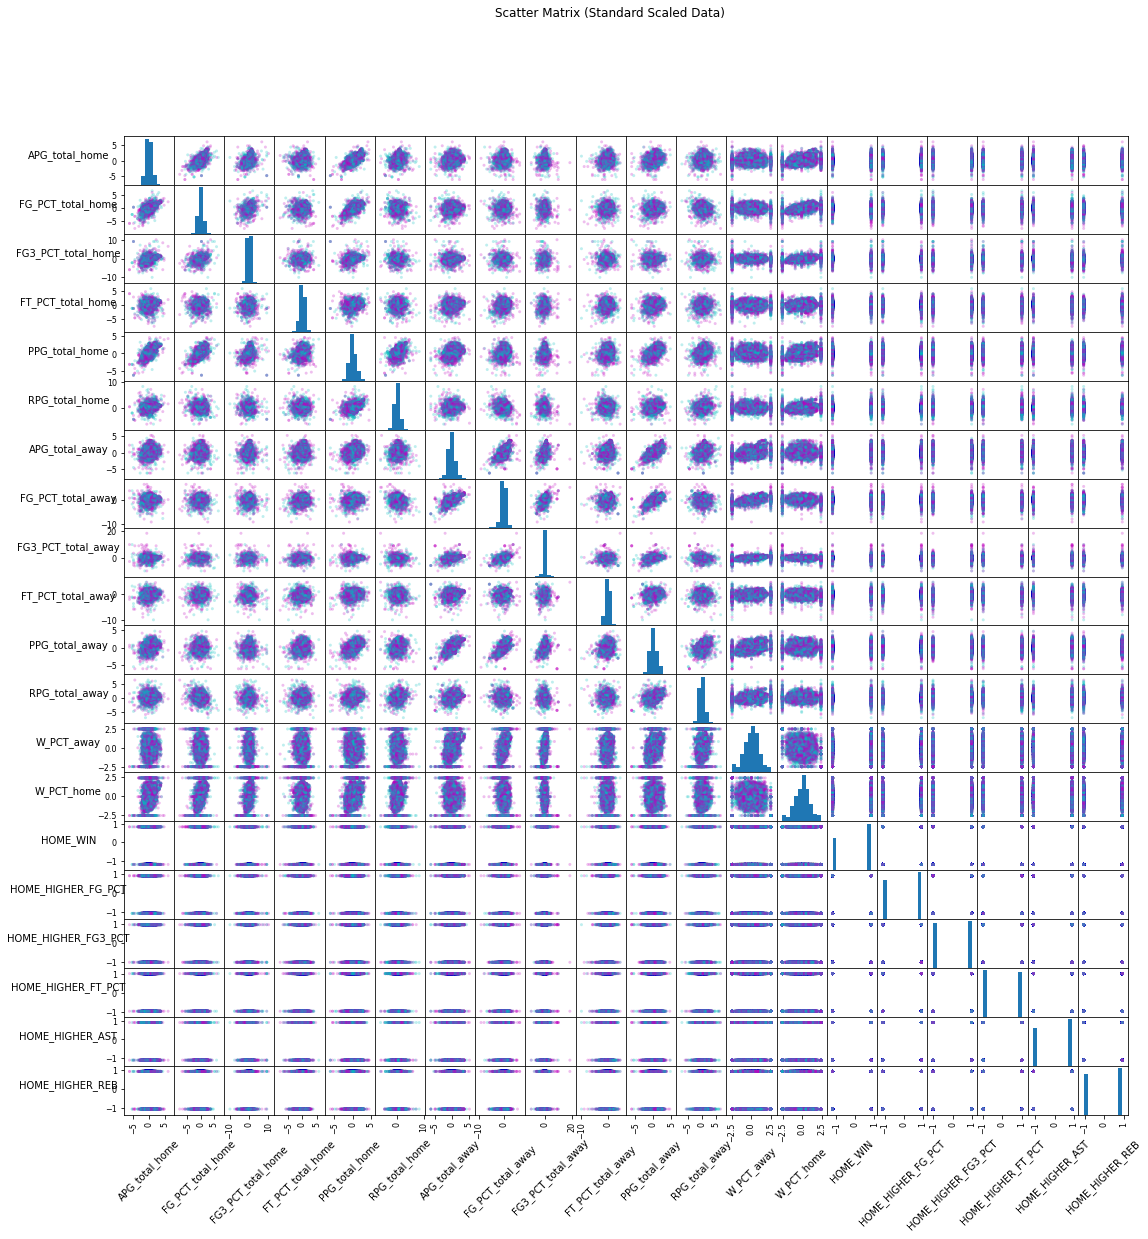

In [22]:
sm=pd.plotting.scatter_matrix(
    standardized_stats_data_df,
    alpha=0.25,
    figsize=(18,18),
    diagonal='hist',
    range_padding=0.3, # More padding to fit labels
    c=['c','m']*(len(standardized_stats_data_df)//2), # Color differentiate points from different data
)
# Rotate & reposition labels
# (referenced https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles)
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(45)
    s.yaxis.label.set_rotation(0)
    s.get_yaxis().set_label_coords(-1.1,0.5)
plt.suptitle('Scatter Matrix (Standard Scaled Data)')
plt.show()

# Train test split 80/20

In [10]:
cumulative_stats_data_df = cumulative_stats_df.copy()

for key in ['DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away']:
    del cumulative_stats_data_df[key]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    cumulative_stats_data_df,
    winners_df,
    train_size=0.8,
    random_state=0,
)

# Train KMeans

In [12]:
kmeans_model = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [13]:
# kmeans_model.score(X_test, y_test)

In [14]:
correct_df = pd.Series([x==y for x,y in zip(kmeans_model.predict(X_test), y_test)])
len(correct_df.loc[correct_df==True])/len(correct_df)

0.4766156462585034

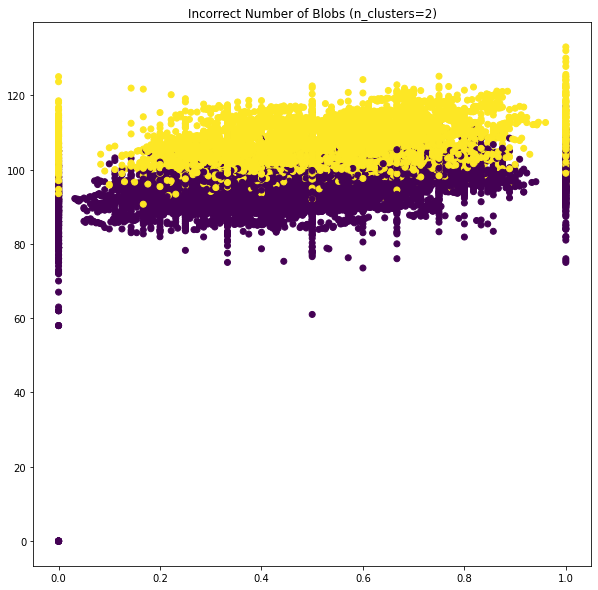

In [84]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['W_PCT_away'], cumulative_stats_data_df['PPG_total_away'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()

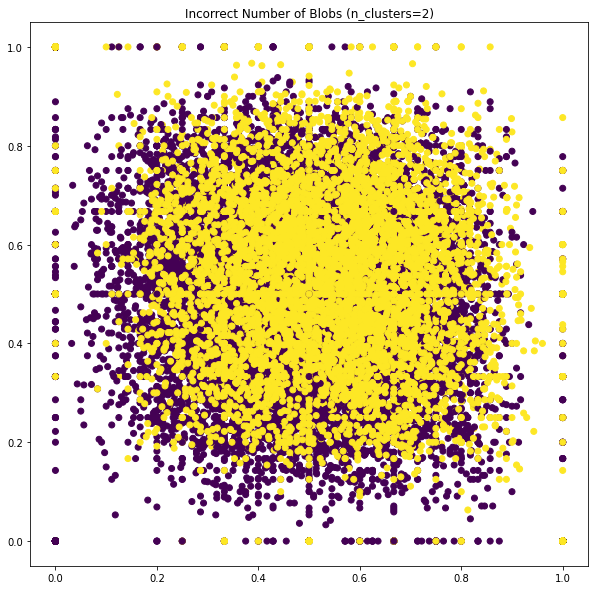

In [83]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['W_PCT_away'], cumulative_stats_data_df['W_PCT_home'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()

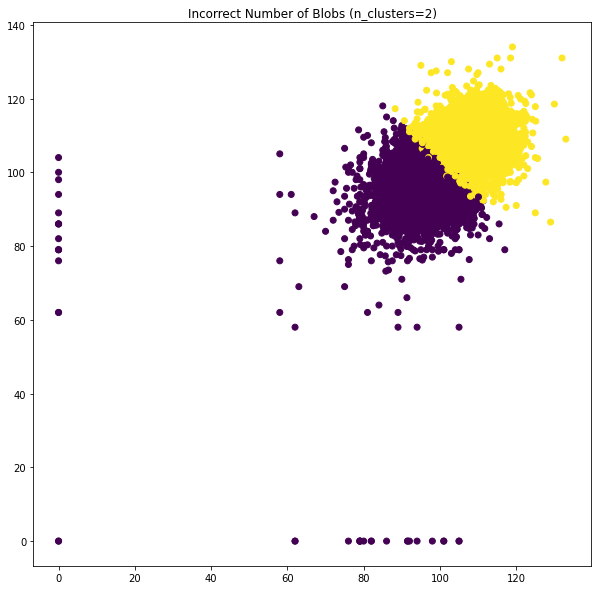

In [68]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['PPG_total_away'], cumulative_stats_data_df['PPG_total_home'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()